# ASSIGNMENT 2

## Task 1

### Import libraries

In [58]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score
from tqdm import tqdm
import time
import copy

### Data Reading, Exploration and preprocessing

In [59]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256,256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

path = '.data/'
train_dataset = datasets.Flowers102(root=path,split='train', transform=transform, download=True)
test_dataset = datasets.Flowers102(root=path,split='test', transform=transform, download=True)
val_dataset = datasets.Flowers102(root=path,split='val', transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Define consts

In [60]:
# Initialize the model, optimizer, and loss function
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using device: {device}")
criterion = nn.CrossEntropyLoss()
nll_criterion = nn.NLLLoss()
num_epochs = 10

Using device: cuda


### Define Training function

In [61]:
# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return epoch_loss, epoch_acc

#### Define Validation function

In [62]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return epoch_loss, epoch_acc

#### Training loop

In [63]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter(comment= f'Model {model.__class__.__name__}')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Update learning rate
        scheduler.step(val_loss)

        # Deep copy the model if best accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/Val', val_loss, epoch)
    writer.add_scalar('Accuracy/Val', val_acc, epoch)
    # writer.add_scalar('F1/Val', test_f1, epoch)

    print(f'Best Val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    # Close TensorBoard writer
    writer.close()
    return model

In [64]:
# def training_model(writer:SummaryWriter,criterion,optimizer,model,epochs:int = 10):
#     epochs = 10
#     # Train the model
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0
#         train_correct = 0
#         for i, (images, labels) in enumerate(train_loader):
#             # Move data to device
#             images = images.to(device)
#             labels = labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Update training loss and accuracy
#             train_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             train_correct += (predicted == labels).sum().item()

#         # Calculate training loss and accuracy
#         train_loss /= len(train_loader)
#         train_accuracy = train_correct / len(train_dataset)

#         # Evaluate the model on the val set
#         model.eval()
#         val_loss = 0
#         val_correct = 0
#         val_labels = []
#         val_predicted = []
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 # Move data to device
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs, 1)
#                 val_correct += (predicted == labels).sum().item()
#                 val_labels.extend(labels.cpu().numpy())
#                 val_predicted.extend(predicted.cpu().numpy())

#         # Calculate test loss and accuracy
#         val_loss /= len(val_loader)
#         val_accuracy = val_correct / len(val_dataset)

#         # Calculate F1 score
#         test_f1 = f1_score(val_labels, val_predicted, average='macro')

#         # Log metrics to TensorBoard
#         writer.add_scalar('Loss/train', train_loss, epoch)
#         writer.add_scalar('Accuracy/train', train_accuracy, epoch)
#         writer.add_scalar('Loss/Val', val_loss, epoch)
#         writer.add_scalar('Accuracy/Val', val_accuracy, epoch)
#         writer.add_scalar('F1/Val', test_f1, epoch)

#         # Print metrics
#         print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
#         print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {test_f1:.4f}')

#     # Close TensorBoard writer
#     writer.close()

# Deep learning Models Definition


In [65]:
# Define the baseline CNN model
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.BatchNorm2d(32),
                                      nn.Dropout(p=0.3),

                                      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.BatchNorm2d(64),
                                      nn.Dropout(p=0.3),

                                      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.BatchNorm2d(128),
                                      nn.Dropout(p=0.3)
                                      )
        self.fc1 = nn.Sequential(nn.Linear(32 * 32 * 128, 512),
                                 nn.ReLU()
                                 )

        self.output = nn.Linear(512, 102)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.output(x)
        x = F.softmax(x, dim=1)
        # x = x.view(x.size(0), -1)  # Flatten
        # x = self.classifier(x)
        return x

BaselineModel()

BaselineModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_

#### Train base model

In [66]:
# Initialize model and training components
base_model = BaselineModel().to(device)
optimizer = optim.SGD(base_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                               patience=3, factor=0.1, verbose=True)

base_model = train_model(base_model, train_loader, val_loader, criterion,
                   optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


Train Loss: 4.6249 Acc: 0.0147


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


Val Loss: 4.6249 Acc: 0.0078

Epoch 2/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


Train Loss: 4.6249 Acc: 0.0176


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


Val Loss: 4.6249 Acc: 0.0088

Epoch 3/10
----------


Training: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Train Loss: 4.6249 Acc: 0.0108


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Val Loss: 4.6249 Acc: 0.0088

Epoch 4/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Train Loss: 4.6247 Acc: 0.0157


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s]


Val Loss: 4.6249 Acc: 0.0088

Epoch 5/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Train Loss: 4.6247 Acc: 0.0206


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


Val Loss: 4.6248 Acc: 0.0088

Epoch 6/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


Train Loss: 4.6247 Acc: 0.0127


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Val Loss: 4.6248 Acc: 0.0098

Epoch 7/10
----------


Training: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Train Loss: 4.6246 Acc: 0.0176


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]


Val Loss: 4.6248 Acc: 0.0108

Epoch 8/10
----------


Training: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


Train Loss: 4.6247 Acc: 0.0186


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


Val Loss: 4.6248 Acc: 0.0108

Epoch 9/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Train Loss: 4.6246 Acc: 0.0127


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s]


Val Loss: 4.6248 Acc: 0.0098

Epoch 10/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Train Loss: 4.6247 Acc: 0.0078


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]

Val Loss: 4.6248 Acc: 0.0098

Best Val Acc: 0.010784


## Transfer Learning using VGG

#### Define VGG model

In [67]:
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model.classifier = nn.Sequential(
                        nn.Linear(25088, 512),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),

                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),

                        nn.Linear(256, 102),
                        nn.LogSoftmax(dim=1))

vgg_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Train VGG

In [ ]:
# Initialize model and training components
vgg_model = vgg_model.to(device)

# Define the optimizer
vgg_optimizer = optim.Adam(vgg_model.classifier.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(vgg_optimizer, mode='min',
                                               patience=3, factor=0.1, verbose=True)

vgg_model = train_model(vgg_model, train_loader, val_loader, criterion,
                   vgg_optimizer, scheduler, num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
----------


Training: 100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


Train Loss: 4.3327 Acc: 0.0686


Validation: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Val Loss: 3.2824 Acc: 0.3108

Epoch 2/10
----------


Training: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


Train Loss: 2.2302 Acc: 0.4333


Validation: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Val Loss: 1.8099 Acc: 0.5569

Epoch 3/10
----------


Training: 100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


Train Loss: 0.7860 Acc: 0.7951


Validation: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Val Loss: 1.5249 Acc: 0.5696

Epoch 4/10
----------


Training:  34%|███▍      | 11/32 [00:07<00:15,  1.40it/s]

## Transfer Learning using ResNet-50

#### Define ResNet-50 model

In [69]:
resnet_model = models.resnet50()
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Sequential(
        nn.Linear(2048, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(128, 102),
        nn.LogSoftmax(dim=1)
    )
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Train ResNet-50 model

In [70]:
resnet_model = resnet_model.to(device)
# Define the optimizer
resnet_optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer, mode='min',
                                               patience=3, factor=0.1, verbose=True)

resnet_model = train_model(resnet_model, train_loader, val_loader, criterion,
                   resnet_optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


Train Loss: 4.7302 Acc: 0.0078


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


Val Loss: 4.6411 Acc: 0.0078

Epoch 2/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


Train Loss: 4.7203 Acc: 0.0118


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Val Loss: 4.6736 Acc: 0.0069

Epoch 3/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


Train Loss: 4.7442 Acc: 0.0049


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Val Loss: 4.6714 Acc: 0.0098

Epoch 4/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Train Loss: 4.7295 Acc: 0.0088


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


Val Loss: 4.6849 Acc: 0.0118

Epoch 5/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


Train Loss: 4.7411 Acc: 0.0069


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Val Loss: 4.6760 Acc: 0.0059

Epoch 6/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


Train Loss: 4.7172 Acc: 0.0127


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Val Loss: 4.6819 Acc: 0.0098

Epoch 7/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.20it/s]


Train Loss: 4.7252 Acc: 0.0088


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


Val Loss: 4.6877 Acc: 0.0078

Epoch 8/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


Train Loss: 4.7155 Acc: 0.0118


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Val Loss: 4.6768 Acc: 0.0069

Epoch 9/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Train Loss: 4.7361 Acc: 0.0127


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


Val Loss: 4.6820 Acc: 0.0108

Epoch 10/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


Train Loss: 4.7448 Acc: 0.0088


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]

Val Loss: 4.6673 Acc: 0.0069

Best Val Acc: 0.011765


### Model performance evaluation

Baseline model test score

In [71]:
validate(base_model, test_loader, criterion)

Validation: 100%|██████████| 193/193 [00:43<00:00,  4.48it/s]

Val Loss: 4.6248 Acc: 0.0133


(4.624786115386734, tensor(0.0133, device='cuda:0', dtype=torch.float64))

VGG-16 test score

In [72]:
validate(vgg_model, test_loader, criterion)

Validation: 100%|██████████| 193/193 [01:12<00:00,  2.67it/s]

Val Loss: 4.6287 Acc: 0.0065


(4.628662051524858, tensor(0.0065, device='cuda:0', dtype=torch.float64))

ResNet-50 test score

In [73]:
validate(resnet_model, test_loader, criterion)

Validation: 100%|██████████| 193/193 [00:58<00:00,  3.32it/s]

Val Loss: 4.6779 Acc: 0.0080


(4.67788528903633, tensor(0.0080, device='cuda:0', dtype=torch.float64))

### Conclusion and possible improvements

## Task 2

### Objective

To cluster images of flowers into distinct groups based on their visual features using unsupervised
learning techniques. The goal is to utilize a pre-trained convolutional neural network (CNN) to
extract features from the images and then apply a clustering algorithm to categorize the flowers

### Feature Extraction

In [74]:
import numpy as np
# Extract features from the flower images
features = []
for images, _ in train_loader:
    images = images.to(device)
    feature_vectors = resnet_model(images)
    features.append(feature_vectors.detach().cpu().numpy())

features = np.concatenate(features, axis=0)

### Clustering: Cluster the extracted features using K-means.

In [75]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Perform K-means clustering on the extracted features
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Reduce the feature dimensionality using PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

### Clusters visualization

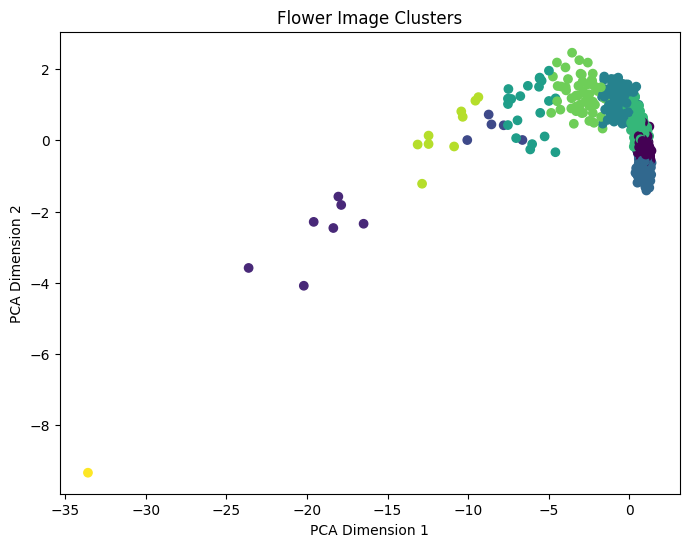

In [76]:
import matplotlib.pyplot as plt

# Plot the clustered data points
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Flower Image Clusters')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()